## Load Data

In [1]:
# Load pickled data
import pickle
import numpy as np 
import tensorflow as tf
import cv2

# TODO: Fill this in based on where you saved the training and testing data
training_file = "data/train.p"
validation_file="data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_test)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print ("Number of classes in training data - {}".format(np.unique( (y_train) ).size))
print ("Number of classes in validation data - {}".format(np.unique( (y_valid) ).size))
print ("Number of classes in test data - {}".format(np.unique( (y_test) ).size))

Number of training examples = 34799
Number of validation examples = 12630
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Number of classes in training data - 43
Number of classes in validation data - 43
Number of classes in test data - 43


### Include an exploratory visualization of the dataset

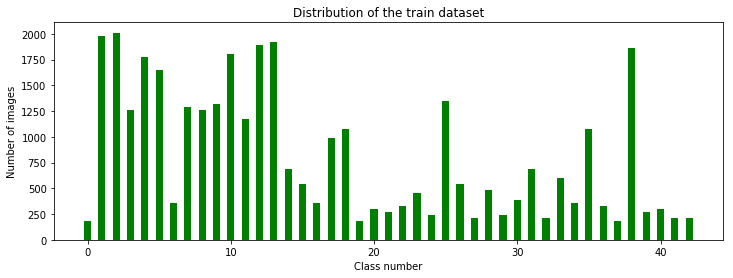

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Visualizations will be shown in the notebook.
%matplotlib inline
#t = np.array( X_train[0], np.float32).reshape( -1, (96,96))
#t.shape
uniq, indices,counts = np.unique(y_train, return_index=True, return_counts=True)

class_samples= {} 
for i,k in zip(indices,counts):
    class_samples[y_train[i]] = k

plt.figure(figsize=(12, 4))
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.bar(list(class_samples.keys()), list(class_samples.values()), 0.5, color='g')
plt.savefig("sample_distribution-1.png")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

In [4]:
def rotate_image(image):
    #flip_image = tf.image.flip_left_right(image)
    ## get a random degree
    degree = np.random.randint(-20, 20)
    img = rotate(image, degree ,reshape=False )
    return image 

def distort_orientation(image, max_rotation,max_translation, max_shear):
   
    ## rotation
    angle = np.random.uniform(max_rotation)-max_rotation/2
    rows,cols,ch = image.shape    
    rotation = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)

    # Translation
    tr_x = max_translation *np.random.uniform()- max_translation/2
    tr_y = max_translation *np.random.uniform()-max_translation/2
    translation = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+max_shear*np.random.uniform()-max_shear/2
    pt2 = 20+max_shear*np.random.uniform()-max_shear/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(image,rotation,(cols,rows))
    img = cv2.warpAffine(img,translation,(cols,rows))
    img = cv2.warpAffine(img,shear,(cols,rows))
    
    return img
    
def distort_color(image):
    rand_bright =   tf.image.random_brightness(image,  0.6, seed=43 )
    rand_contrast = tf.image.random_contrast(image, 0.1, 0.6,seed=48)
    rand_saturation = tf.image.random_saturation(image,0.1, 0.6,seed=45 )
    rand_hue = tf.image.random_hue(image, 0.5, seed=49)
    return (rand_bright, rand_contrast,rand_saturation, rand_hue)  

In [5]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

## shuffle training data
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
import random

print(X_train.shape, y_train.shape)

aug_train = [] 
aug_label = []

aug_X = []
aug_y = []
max_samples_per_class = 4500
#for train, label in zip(X_train, y_train):
#    factor = int(max_samples_per_class/class_samples[label]) -1
#    for i in range(factor):
#        aug_train.append(rotate_image(train))
#        aug_label.append(label)
  

#ax_train =  np.asarray(aug_train)
#ay_train = np.asarray(aug_label)
#print( X_train.shape, y_train.shape, ax_train.shape, ay_train.shape)

for train,label in zip(X_train, y_train):
    for i in range(10):
        aug_X.append(distort_orientation(train, 20, 5, 10))
        aug_y.append(label)
        
aug_X = np.asarray(aug_X)
aug_y = np.asarray(aug_y)
print (aug_X.shape, aug_y.shape)

ax_train,ax_valid, ay_train, ay_valid = train_test_split( aug_X, aug_y, test_size=0.25, random_state=42)

## Add augmented data 
X_train_new = np.concatenate(( X_train, ax_train), axis=0 )
y_train_new = np.concatenate((y_train, ay_train),axis=0)
X_valid = np.concatenate((X_valid, ax_valid), axis=0)
y_valid = np.concatenate((y_valid, ay_valid), axis=0)
print ("Augmented training data size - ")
print( X_train_new.shape, y_train_new.shape )
print ("Augmented validation data size - ")
print( X_valid.shape, y_valid.shape )

X_train, y_train = shuffle(X_train_new, y_train_new)
X_valid, y_valid = shuffle(X_valid, y_valid)

(34799, 32, 32, 3) (34799,)
(347990, 32, 32, 3) (347990,)
Augmented training data size - 
(295791, 32, 32, 3) (295791,)
Augmented validation data size - 
(91408, 32, 32, 3) (91408,)


New training data distribution - 


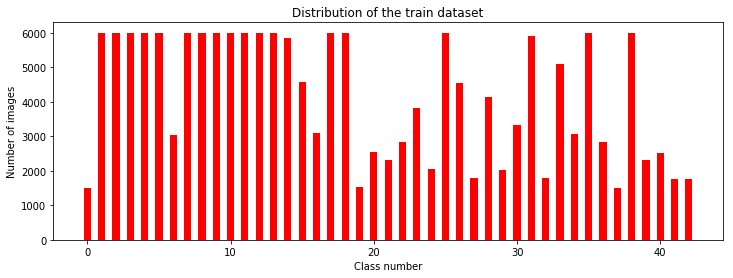

In [6]:
## pick evenly from each class
X_picked = []
y_picked = []
cur_count = {}
for c in class_samples.keys():
    cur_count[c]=0 

for train,label in zip(X_train, y_train): 
    if ( cur_count[label] < 6000 ):
        X_picked.append(train)
        y_picked.append(label)
        cur_count[label] +=1
X_train =  np.asarray(X_picked)
y_train = np.asarray(y_picked)

#print( X_train.shape, y_train.shape)

uniq, indices,counts = np.unique(y_train, return_index=True, return_counts=True)

class_samples= {} 
for i,k in zip(indices,counts):
    class_samples[y_train[i]] = k

print("New training data distribution - ")
#print(class_samples)
plt.figure(figsize=(12, 4))
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.bar(list(class_samples.keys()), list(class_samples.values()), 0.5, color='r')
plt.savefig("sample_distribution-2.png")


In [7]:
## color normalization

import cv2
def convert_to_yuv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

def color_normalization(images):
    res_images = []
    for image in images:
        img_yuv = convert_to_yuv(image)
        # apply histogram normalization
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        y_ = clahe.apply(img_yuv[:,:,0])
        img_yuv[:,:,0]= y_
        res_images.append(img_yuv)
    return np.asarray(res_images)

def  feature_normalization(images):
    return images/255. * 0.8 + 0.1
  


In [8]:
print("Normalizing colors....")
X_train = color_normalization(X_train)
#print( X_train.shape, y_train.shape)
X_valid = color_normalization(X_valid)
#print( X_valid.shape, y_valid.shape)
X_test = color_normalization(X_test)
#print( X_test.shape, y_test.shape)

## Feature normalization
# Normalize features
print('Normalizing features...')
X_train = feature_normalization(X_train)
X_valid = feature_normalization(X_valid)
X_test = feature_normalization(X_test)

Normalizing colors....
Normalizing features...


### Model Architecture

In [9]:
import tensorflow as tf

EPOCHS = 80
BATCH_SIZE = 128



In [10]:
## New architecture 
import tensorflow.contrib.slim as slim
from tensorflow.contrib.layers.python.layers import initializers

## Inception Architecture for Traffic Sign Classifier
def InceptTraffic(x):
    
    mu = 0
    sigma = 0.1
    ## Layer 1
    ## 1x1 convolution
    branch_1_0 = slim.conv2d(x, 8, [1, 1] )
    ## 1x1 convolution + 5x5 conv
    branch_1_1 = slim.conv2d(x, 8, [1,1])
    branch_1_1 = slim.conv2d(branch_1_1, 16, [5,5])
    ## 1x1 convolution + 3x3 conv
    branch_1_2 = slim.conv2d(x, 16, [1,1])
    branch_1_2 = slim.conv2d(branch_1_2, 32, [3,3])
    ## Maxpool 
    #branch_1_3 = slim.max_pool2d(x, [3,3] )
    branch_1_3 = slim.conv2d(x, 32, [1, 1])
    
    ## combine them
    conv2d_1 = tf.concat(axis=3, values=[branch_1_0, branch_1_1, branch_1_2, branch_1_3])
    conv2d_1 = slim.max_pool2d(conv2d_1, [3,3], stride=2)
    #print(conv2d_1.shape)
    ## dropout
    res = slim.dropout(conv2d_1,keep_prob=0.7, scope='Dropout_1')

    
    ## Layer 2 - input 15X15X88
    branch_2_0 = slim.conv2d(res, 88, [5,5])
    branch_2_1 = slim.max_pool2d(branch_2_0, [3,3],stride=1)
    ## dropout
    #res = slim.dropout(branch_2_1,keep_prob=0.7, scope='Dropout_2')
    #print(res.shape)
    
     ## Layer 3 - input 13X13x120
    branch_3_0 = slim.conv2d(branch_2_1, 100, [5,5])
    branch_3_1 = slim.max_pool2d(branch_3_0, [4,4], stride=2)
    ## dropout
    #res = slim.dropout(branch_3_1,keep_prob=0.7, scope='Dropout_3')
    
    #print(res.shape)
    ## flatten 
    #  Input = 5x5x100. Output = 2500.
    flat = tf.contrib.layers.flatten(branch_3_1)
    ## fully connected layer
    #print(flat.shape)
    
     # TODO: Layer 3: Fully Connected. Input = 1200. Output = 400.
    weight_f1 = tf.Variable( tf.random_normal( [2500,1000], mean = mu, stddev=sigma))
    bias_f1 = tf.Variable(tf.zeros(1000))
    fc1 = tf.add(tf.matmul(flat,weight_f1),bias_f1)
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    #print(fc1.shape)
    
    # TODO: Layer 4: Fully Connected. Input = 400. Output = 130.
    weight_f2 = tf.Variable( tf.random_normal( [1000,500], mean = mu, stddev=sigma))
    bias_f2 = tf.Variable(tf.zeros(300))
    fc2 = tf.add(tf.matmul(fc1,weight_f2),bias_f2)
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    #print(fc2.shape)
    
    # TODO: Layer 5: Fully Connected. Input = 130. Output = 43.
    weight_f3 = tf.Variable( tf.random_normal( [500,43], mean = mu, stddev=sigma))
    bias_f3 = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(fc2,weight_f3),bias_f3)
    
    return logits

    

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def LeNet(x,phase):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1


    #  Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x12.
    weights_layer_1 = tf.Variable(tf.random_normal([5,5,3,12], mean = mu, stddev=sigma))
    bias_layer_1 = tf.Variable(tf.zeros([12]))
    # Activation.
    conv1 = tf.nn.conv2d(x, weights_layer_1, strides=[1, 1, 1, 1], padding='VALID') + bias_layer_1
    conv1 = tf.nn.relu(conv1,name="relu1")
    #print( conv1.shape)
    #  Pooling. Input = 28x28x12. Output = 26x26x12.
    pool1 = tf.nn.max_pool(conv1,ksize=[1,3,3,1], strides=[1,1,1,1], padding='VALID' )
    #pool1 = tf.layers.dropout( pool1, rate=0.1, training=True)
    #print( "pool1 - ")
    #print( pool1.shape )
    
    weights_layer_1b = tf.Variable(tf.random_normal([1,1,12,30], mean = mu, stddev=sigma))
    bias_layer_1b  = tf.Variable(tf.zeros([30]))
    conv1b = tf.nn.conv2d(pool1, weights_layer_1b, strides=[1, 1, 1, 1], padding='VALID') + bias_layer_1b
    conv1b = tf.nn.relu(conv1b, name="relu1b")
    
    
    # TODO: Layer 2: Convolutional. Input - 26x26x30 Output = 22x22x48.
    weights_layer_2 = tf.Variable(tf.random_normal([5,5,30,48], mean = mu, stddev=sigma))
    bias_layer_2 = tf.Variable(tf.zeros([48]))
    conv2 = tf.nn.conv2d(conv1b, weights_layer_2, strides=[1, 1, 1, 1], padding='VALID') + bias_layer_2
    # Activation.
    conv2 = tf.nn.relu(conv2,name="relu2")
    # Pooling. Input = 22x22x48. Output = 11x11x48.
    pool2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID' )
    #pool2 = tf.layers.dropout( pool2, rate=0.1, training=True)
    #print( "pool2 - ")
    #print( pool2.shape )
    
    
    weights_layer_2b = tf.Variable(tf.random_normal([1,1,48,76], mean = mu, stddev=sigma))
    bias_layer_2b  = tf.Variable(tf.zeros([76]))
    conv2b = tf.nn.conv2d(pool2, weights_layer_2b, strides=[1, 1, 1, 1], padding='VALID') + bias_layer_2b
    conv2b = tf.nn.relu(conv2b,name="relu2b")
    
    
    #  Convolutional. Input - 11x11x76 Output = 7x7x120.
    weights_layer_3 = tf.Variable(tf.random_normal([5,5,76,120], mean = mu, stddev=sigma))
    bias_layer_3 = tf.Variable(tf.zeros([120]))
    conv3 = tf.nn.conv2d(conv2b, weights_layer_3, strides=[1, 1, 1, 1], padding='VALID') + bias_layer_3
    # Activation.
    conv3 = tf.nn.relu(conv3,name="relu3")
    # Pooling. Input = 7x7x120. Output = 5x5x120.
    pool3 = tf.nn.max_pool(conv3,ksize=[1,3,3,1], strides=[1,1,1,1], padding='VALID' )
    #pool3 = tf.layers.dropout( pool3, rate=0.1, training=True)
    #print( "pool3 - ")
    #print( pool3.shape )
    

    
    
    #  Flatten. Input = 5x5x120. Output = 3000.
    flat = tf.contrib.layers.flatten(pool3)
    #print(flat.shape)
    
    
    # Layer 3: Fully Connected. Input = 3000. Output = 1500.
    weight_f1 = tf.Variable( tf.random_normal( [3000,1500], mean = mu, stddev=sigma))
    bias_f1 = tf.Variable(tf.zeros(1500))
    fc1 = tf.add(tf.matmul(flat,weight_f1),bias_f1)
    
    ## batch normalization
    ## different behaviors during training and testing
    fc1 = tf.contrib.layers.batch_norm(fc1,center=True, scale=True, 
                                          is_training=phase)
    # Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.layers.dropout(fc1, rate=0.3, training=phase)
    #print(fc1.shape)
    
    # Layer 4: Fully Connected. Input = 1500. Output = 700.
    weight_f2 = tf.Variable( tf.random_normal( [1500,700], mean = mu, stddev=sigma))
    bias_f2 = tf.Variable(tf.zeros(700))
    fc2 = tf.add(tf.matmul(fc1,weight_f2),bias_f2)
    
    ## batch normalization
    ## different behaviors during training and testing
    fc2 = tf.contrib.layers.batch_norm(fc2,center=True, scale=True, 
                                          is_training=phase)
    #  Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.layers.dropout(fc2, rate=0.3, training=phase)
    #print(fc2.shape)
    
    
    # Layer 5: Fully Connected. Input = 700. Output = 300.
    weight_f3 = tf.Variable( tf.random_normal( [700,300], mean = mu, stddev=sigma))
    bias_f3 = tf.Variable(tf.zeros(300))
    fc3 = tf.add(tf.matmul(fc2,weight_f3),bias_f3)
    ## batch normalization
    ## different behaviors during training and testing
    fc3 = tf.contrib.layers.batch_norm(fc3,center=True, scale=True, is_training=phase)
    fc3 = tf.nn.relu(fc3)
    fc3 = tf.layers.dropout(fc3, rate=0.3, training=phase)
    
    weight_f4 = tf.Variable( tf.random_normal( [300,43], mean = mu, stddev=sigma))
    bias_f4 = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(fc3,weight_f4),bias_f4)
 
    #print(logits.shape)
    
    return logits







In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
phase = tf.placeholder(bool,name="phase")
one_hot_y = tf.one_hot(y, 43)

### Training Pipeline

In [13]:
rate = 0.001

#logits = InceptTraffic(x)
logits = LeNet(x,phase)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
probabilities=tf.nn.softmax(logits)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
        # Ensures that we execute the update_ops before performing the train_step
    optimizer = tf.train.AdamOptimizer(learning_rate = rate, epsilon=0.1)
    training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, phase:0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

In [ ]:
import time
inital_time = time.time()

training_acc = []
validation_acc = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, phase:1})
        
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        training_acc.append(training_accuracy)
        validation_acc.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print ("Finished EPOCH -", i+1, "in ", round((time.time()-inital_time)/60.)," minutes")
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        if ( i% 10 ==0):
            saver.save(sess, './TrafficSignClassifier')
            print("Model saved")
        
       
    print ("Finishedin ", round((time.time()-inital_time)/60.)," minutes")    
    saver.save(sess, './TrafficSignClassifier')
    print("Model saved")

Training...

EPOCH 1 ...
Finished EPOCH - 1 in  1  minutes
Training Accuracy = 0.112
Validation Accuracy = 0.107

Model saved
EPOCH 2 ...
Finished EPOCH - 2 in  3  minutes
Training Accuracy = 0.329
Validation Accuracy = 0.337

EPOCH 3 ...
Finished EPOCH - 3 in  4  minutes
Training Accuracy = 0.264
Validation Accuracy = 0.265

EPOCH 4 ...
Finished EPOCH - 4 in  5  minutes
Training Accuracy = 0.527
Validation Accuracy = 0.517

EPOCH 5 ...
Finished EPOCH - 5 in  7  minutes
Training Accuracy = 0.574
Validation Accuracy = 0.575

EPOCH 6 ...
Finished EPOCH - 6 in  8  minutes
Training Accuracy = 0.526
Validation Accuracy = 0.511

EPOCH 7 ...
Finished EPOCH - 7 in  9  minutes
Training Accuracy = 0.512
Validation Accuracy = 0.513

EPOCH 8 ...
Finished EPOCH - 8 in  10  minutes
Training Accuracy = 0.702
Validation Accuracy = 0.702

EPOCH 9 ...
Finished EPOCH - 9 in  12  minutes
Training Accuracy = 0.771
Validation Accuracy = 0.763

EPOCH 10 ...
Finished EPOCH - 10 in  13  minutes
Training Accura

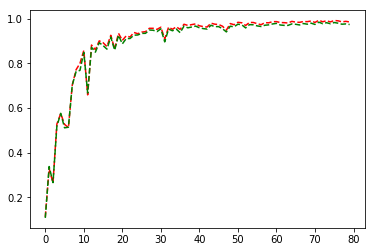

In [ ]:
## Plot Accuracy curves

#for i in range(len(training_acc) ):
plt.plot(training_acc,'r--', validation_acc, 'g--')
plt.show()
plt.savefig("accuracy_plot.png")

#### Evaluate on Test set

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.964


## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

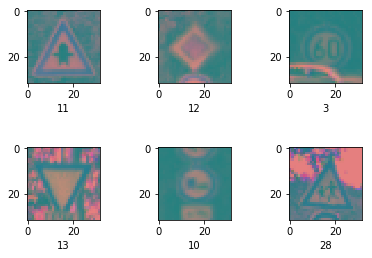

In [29]:
cur_f = {}
for c in class_samples.keys():
    cur_f[c]=0
    
fig, axes = plt.subplots(2, 3)
fig.subplots_adjust(hspace=.7,wspace=0.8)

new_y = [28,12,11,3,10,13]
samples = []
for i,l in zip(X_test,y_test):
    if (l in new_y and cur_f[l] ==  0):
        #plt.figure(figsize=(5,5))
        samples.append((i,l))
        #axes.imshow(i)
        #axes.set_xlabel(l,fontsize=6)
        #print(l)
        cur_f[l] = 1

for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i][0])
    ax.set_xlabel(samples[i][1],fontsize=10)
    

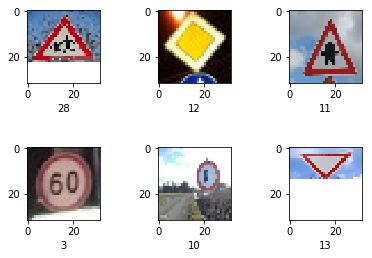

In [30]:
import matplotlib.image as mpimg
from PIL import Image

fig, axes = plt.subplots(2, 3)
fig.subplots_adjust(hspace=.7,wspace=0.8)

test_img_path = "test_images/"
imgs = ['test_img1.jpg','2.jpeg','test_img3.jpeg','8.jpeg','test_img5.jpeg','test_img6.jpg']
new_input = []
new_y = [28,12,11,3,10,13]

for i, ax in enumerate(axes.flat):
    image = np.asarray(Image.open(test_img_path + imgs[i]).resize((32,32)))
    ax.imshow(image)
    ax.set_xlabel(new_y[i],fontsize=10)
    new_input.append(image)

#for i in imgs:
#    image = np.asarray(Image.open(test_img_path + i).resize((32,32)))
#    
#    plt.figure(figsize=(5,5))
#    plt.imshow(image)
#    new_input.append(image)


new_input = np.asarray(new_input)
new_y = np.asarray(new_y)

## Normalization
new_input = color_normalization(new_input)
new_input = feature_normalization(new_input)
#print(new_input.shape)
#print(new_y.shape)

### Predict the Sign Type for Each Image


In [31]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred = sess.run(logits, feed_dict={x: new_input, y: new_y, phase:0})
    values, indices = tf.nn.top_k(pred, k=5)
    
    values = values.eval()
    indices = indices.eval()
    print("Predicted value, True value")
    j=0
    correct_pred = 0.
    for p in pred:
        predicted_val = int( tf.argmax(p,0).eval() )
        print(predicted_val, new_y[j])
        if(predicted_val == new_y[j] ):
            correct_pred +=1
        j+=1
    
ac = correct_pred / j
print ("Accuracy is {}".format(ac))

Predicted value, True value
28 28
12 12
11 11
1 3
1 10
13 13
Accuracy is 0.6666666666666666


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [32]:
print("Top 5 classes with softmax probabilites.. ")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction = probabilities.eval(session=sess,feed_dict={x: new_input, y: new_y, phase:0})
    #print (prediction.shape)#

Top 5 classes with softmax probabilites.. 


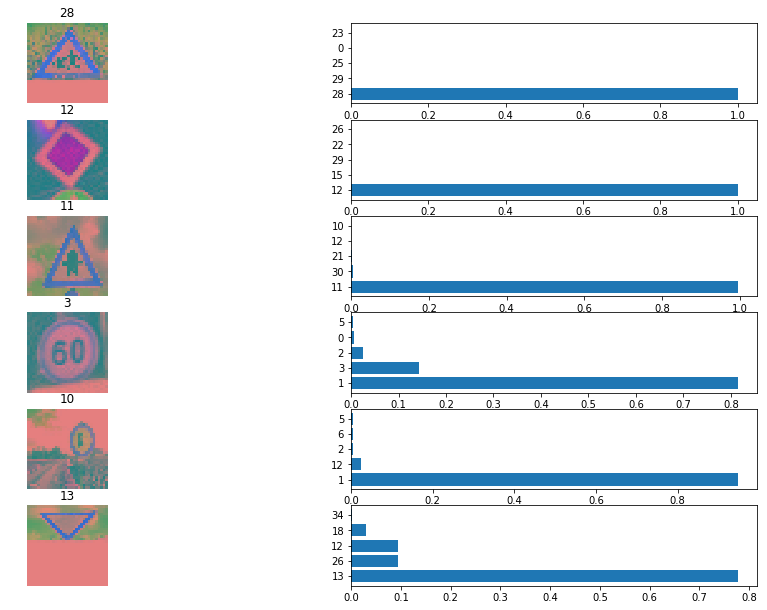

In [33]:


plt.figure(figsize=(16, 21))
for i in range(6):
    pred = list(prediction[i])
    top_5 = sorted(range(len(pred)), key=lambda i: pred[i] , reverse=True)[:5]
    prob_5 = []
    [prob_5.append(pred[i]) for i in top_5 ]
    plt.subplot(12, 2, 2*i+1)
    plt.imshow(new_input[i]) 
    plt.title(new_y[i])
    plt.axis('off')
    plt.subplot(12, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), prob_5)
    labs=[j for j in top_5]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()



## Step 4: Visualize the Neural Network's State with Test Images


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    #image_input = tf.Variable(image_input)
    
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

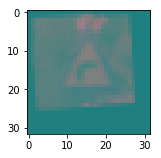

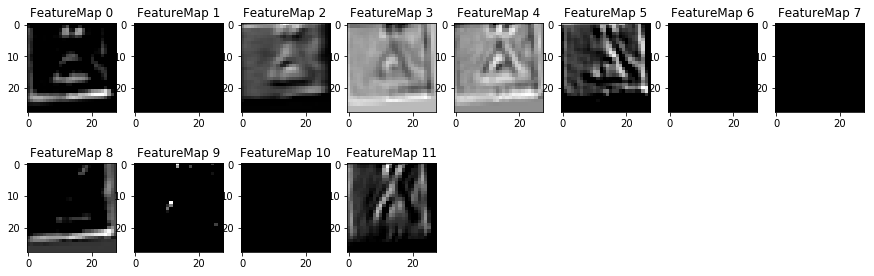

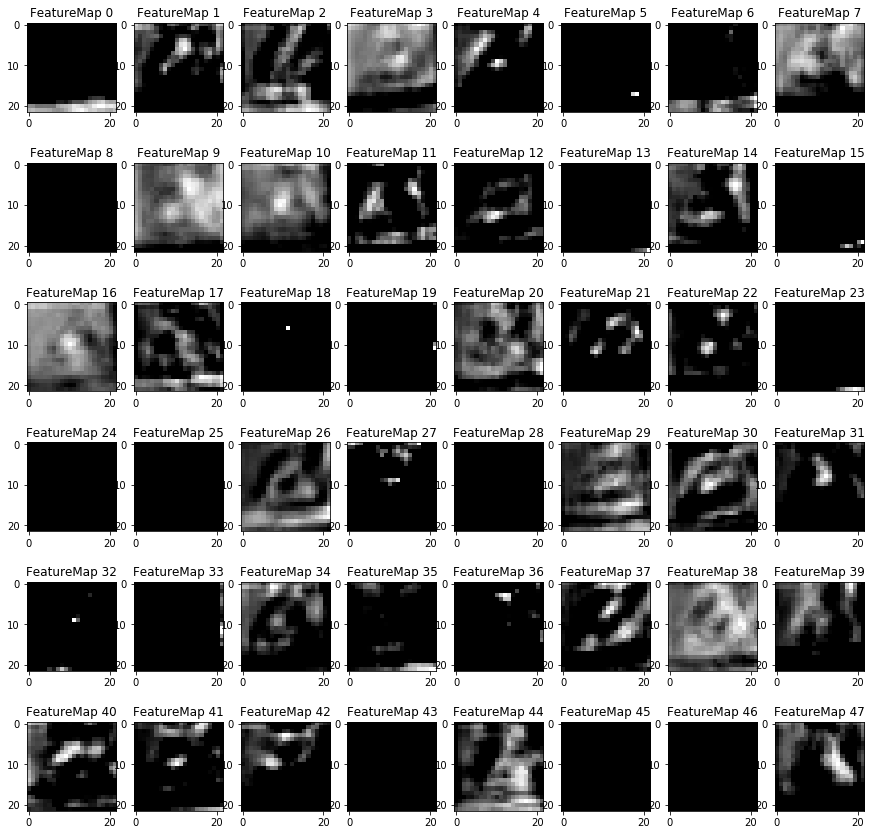

In [35]:
test_image = np.asarray(X_train[20:21])
plt.figure(2,figsize=(5,5))
plt.subplot(212)
plt.imshow(test_image[0])
#print (test_image.shape)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    # Fetch the tensor with name 'conv1:0'
    conv1 = sess.graph.get_tensor_by_name('relu1:0')
    outputFeatureMap(test_image,conv1,plt_num=3)
    conv2 = sess.graph.get_tensor_by_name('relu2:0')
    outputFeatureMap(test_image,conv2,plt_num=4)
    #conv3 = sess.graph.get_tensor_by_name('relu3:0')
    #outputFeatureMap(test_image,conv3,plt_num=5)

Question 9
Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images

As we can see from above illustrations, activations at different layers have learned the abstractions required for it to be to recognize the sign. 
At lower layes the activations seem to be more about the shape of the sign irrespective of its position or rotation. 